In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import camera_calibration_show_extrinsics as show
from PIL import Image

Start finding chessboard corners...
find the chessboard corners of data_one-sided/0001.jpg
find the chessboard corners of data_one-sided/0007.jpg
find the chessboard corners of data_one-sided/0009.jpg
find the chessboard corners of data_one-sided/0006.jpg
find the chessboard corners of data_one-sided/0005.jpg
find the chessboard corners of data_one-sided/0003.jpg
find the chessboard corners of data_one-sided/0004.jpg
find the chessboard corners of data_one-sided/0011.jpg
find the chessboard corners of data_one-sided/0008.jpg
find the chessboard corners of data_one-sided/0002.jpg
find the chessboard corners of data_one-sided/0010.jpg
find the chessboard corners of data_one-sided/0000.jpg


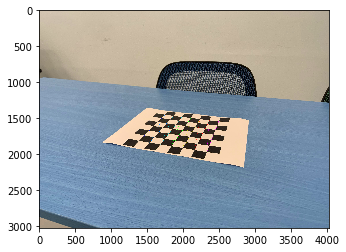

In [33]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# (8,6) is for the given testing images.
# If you use the another data (e.g. pictures you take by your smartphone), 
# you need to set the corresponding numbers.
corner_x = 7
corner_y = 7
objp = np.zeros((corner_x*corner_y,3), np.float32)
objp[:,:2] = np.mgrid[0:corner_x, 0:corner_y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('data_one-sided/*.jpg')

# Step through the list and search for chessboard corners
print('Start finding chessboard corners...')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)

    #Find the chessboard corners
    print('find the chessboard corners of',fname)
    ret, corners = cv2.findChessboardCorners(gray, (corner_x,corner_y), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (corner_x,corner_y), corners, ret)
        plt.imshow(img)

In [3]:
#######################################################################################################
#                                Homework 1 Camera Calibration                                        #
#               You need to implement camera calibration(02-camera p.76-80) here.                     #
#   DO NOT use the function directly, you need to write your own calibration function from scratch.   #
#                                          H I N T                                                    #
#                        1.Use the points in each images to find Hi                                   #
#                        2.Use Hi to find out the intrinsic matrix K                                  #
#                        3.Find out the extrensics matrix of each images.                             #
#######################################################################################################

In [34]:
print('Camera calibration...')
img_size = (img.shape[1], img.shape[0])
# You need to comment these functions and write your calibration function from scratch.
# Notice that rvecs is rotation vector, not the rotation matrix, and tvecs is translation vector.
# In practice, you'll derive extrinsics matrixes directly. The shape must be [pts_num,3,4], and use them to plot.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
Vr = np.array(rvecs)
Tr = np.array(tvecs)
extrinsics = np.concatenate((Vr, Tr), axis=1).reshape(-1,6)

Camera calibration...


In [16]:
def CameraCalibrate(objpoints, imgpoints, corner_x, corner_y):
    # Build Homography H
    H = []
    for objp, imgp in zip(objpoints, imgpoints):
        P = np.zeros((corner_x*corner_y*2,9))
        for i in range(corner_x*corner_y):
            P[i*2] = [objp[i,0],objp[i,1],1,0,0,0,-imgp[i,0,0]*objp[i,0],-imgp[i,0,0]*objp[i,1],-imgp[i,0,0]*1]
            P[i*2+1] = [0,0,0,objp[i,0],objp[i,1],1,-imgp[i,0,1]*objp[i,0],-imgp[i,0,1]*objp[i,1],-imgp[i,0,1]*1]
        U,D,V = np.linalg.svd(P)
        m = V.T[:,-1]
        m = m/m[-1]
        H.append(m.reshape((3,3)))
        
    # V for Vb=0
    V = np.zeros((len(H)*2,6))
    for i,h in enumerate(H):
        V[i*2] = [
            h[0,0]*h[0,1],
            h[0,0]*h[1,1]+h[1,0]*h[0,1],
            h[1,0]*h[1,1],
            h[2,0]*h[0,1]+h[0,0]*h[2,1],
            h[2,0]*h[1,1]+h[1,0]*h[2,1],
            h[2,0]*h[2,1]
        ]
        V[i*2+1] = [
            h[0,0]*h[0,0]-h[0,1]*h[0,1],
            (h[0,0]*h[1,0]-h[0,1]*h[1,1])*2,
            h[1,0]*h[1,0]-h[1,1]*h[1,1],
            (h[2,0]*h[0,0]-h[2,1]*h[0,1])*2,
            (h[2,0]*h[1,0]-h[1,1]*h[2,1])*2,
            h[2,0]*h[2,0]-h[2,1]*h[2,1]
        ]
    U,D,V = np.linalg.svd(V)
    b = V.T[:,-1]
    B = np.array([
        [b[0],b[1],b[3]],
        [b[1],b[2],b[4]],
        [b[3],b[4],b[5]]
    ])
    # intrinsic matrix K
    K_inv = np.linalg.cholesky(B).T
    K = np.linalg.inv(K_inv)
    K = K/K[-1,-1]
    
    # extrinsic matrix
    K_inv = np.linalg.inv(K)
    rvecs = []
    tvecs = []
    for h in H:
        h1 = h[:,0]
        h2 = h[:,1]
        h3 = h[:,2]
        lamda = 1/(np.linalg.norm(K_inv.dot(h1),2))
        r1 = lamda*K_inv.dot(h1)
        r2 = lamda*K_inv.dot(h2)
        r3 = np.cross(r1,r2)
        rotation_matrix = np.zeros((3, 3))
        rotation_matrix[:,0] = r1
        rotation_matrix[:,1] = r2
        rotation_matrix[:,2] = r3

        r,_= cv2.Rodrigues(rotation_matrix)
        t = lamda*K_inv.dot(h3).reshape(-1,1)
        rvecs.append(r)
        tvecs.append(t)
    return K, rvecs, tvecs

In [37]:
mtx, rvecs, tvecs = CameraCalibrate(objpoints, imgpoints, corner_x, corner_y)
extrinsics = np.concatenate((rvecs, tvecs), axis=1).reshape(-1,6)

Show the camera extrinsics


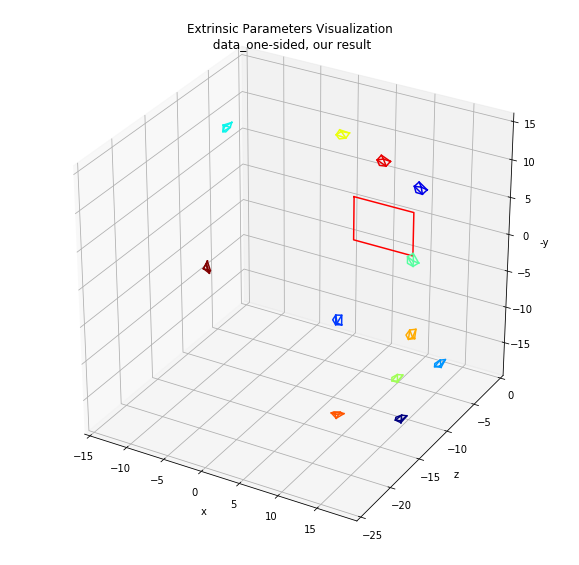

'\nfor angle in range(0, 360):\n    ax.view_init(30, angle)\n    plt.draw()\n    plt.pause(.001)\n'

In [38]:
# show the camera extrinsics
print('Show the camera extrinsics')
# plot setting
# You can modify it for better visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# camera setting
camera_matrix = mtx
cam_width = 0.064/0.1
cam_height = 0.032/0.1
scale_focal = 1600
# chess board setting
board_width = 8
board_height = 6
square_size = 1
# display
# True -> fix board, moving cameras
# False -> fix camera, moving boards
min_values, max_values = show.draw_camera_boards(ax, camera_matrix, cam_width, cam_height,
                                                scale_focal, extrinsics, board_width,
                                                board_height, square_size, True)

X_min = min_values[0]
X_max = max_values[0]
Y_min = min_values[1]
Y_max = max_values[1]
Z_min = min_values[2]
Z_max = max_values[2]
max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max() / 2.0

mid_x = (X_max+X_min) * 0.5
mid_y = (Y_max+Y_min) * 0.5
mid_z = (Z_max+Z_min) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, 0)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('-y')
ax.set_title('Extrinsic Parameters Visualization\n data_one-sided, our result')

plt.savefig('Results/data_onesided_us')
plt.show()

#animation for rotating plot
"""
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
"""